In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../')
import progressbar as P
from helper import getLLPs,getModelDict,splitModels
from ATLAS_data.effFunctions import (getMuonRecoEff,getTriggerEff,getTrackEff,
                                     getSelectionEff,getTargetMass,getMassSelEff,
                                     massLong,massShort)
from atlas_susy_2018_42_Recast import getHSCPCandidates,applyHSCPSelection,applyMuonTagging,removeFromMET

delphesDir = os.path.abspath("../DelphesLLP")
os.environ['ROOT_INCLUDE_PATH'] = os.path.join(delphesDir,"external")

import ROOT
import xml.etree.ElementTree as ET


ROOT.gSystem.Load(os.path.join(delphesDir,"libDelphes.so"))

ROOT.gInterpreter.Declare('#include "classes/SortableObject.h"')
ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps['RdYlBu']

Welcome to JupyROOT 6.28/06


In [12]:
# inputFile = '../eventData/pp2Gluino_atlas_scan/Events/run_08/gluino_400_370.0_tau_3e+01_delphes_events.root'
# inputFile = '../eventData/pp2BB1j_atlas_scan_hscp/Events/run_06/cdfo_105_100.0_tau_6e+00_delphes_events.root'
inputFiles = ['../eventData/pp2BB1j_atlas_scan_hscp/Events/run_08/cdfo_1005_1000.0_tau_1e+01_delphes_events.root',
              '../eventData/pp2BB1j_atlas_scan_hscp/Events/run_09/cdfo_1005_1000.0_tau_5e+00_delphes_events.root']

In [13]:
nLLPs_dict = {}
nCharged_dict = {}
RDV_dict = {}
eta_dict = {}
for i,inputFile in enumerate(inputFiles):
    f = ROOT.TFile(inputFile,'read')
    tree = f.Get("Delphes")
    nevts = tree.GetEntries()
    ntotal = 0
    nLLPs = []
    nCharged = []
    RDV = []
    eta = []
    for ievt in range(nevts):    
        
        ntotal += 1
        tree.GetEntry(ievt)   
        weightPB = tree.Event.At(0).Weight/nevts

        metCalo = tree.MissingETCalo.At(0).MET
        llps = getLLPs(tree.bsm,tree.bsmDirectDaughters,tree.bsmFinalDaughters,tree.bsmMothers)
        # if len(llps) != 2:
            # break
        nLLPs.append(len(tree.bsm))
        # nRhadron.append(len(tree.rhadrons))
        # nRhadronIso.append(len(tree.isorhadrons))
        hscpCandidates = getHSCPCandidates(llps)
        nCharged.append(len(hscpCandidates))
        for hscp in hscpCandidates:
            RDV.append(hscp.r_decay)
            eta.append(hscp.Eta)
        # hscpCandidates = getHSCPCandidates(tree.isoRhadrons,tree.rhadronDaughters,llps)
        # break
    f.Close()
    nLLPs_dict[i] = nLLPs
    nCharged_dict[i] = nCharged
    RDV_dict[i] = RDV
    eta_dict[i] = eta    


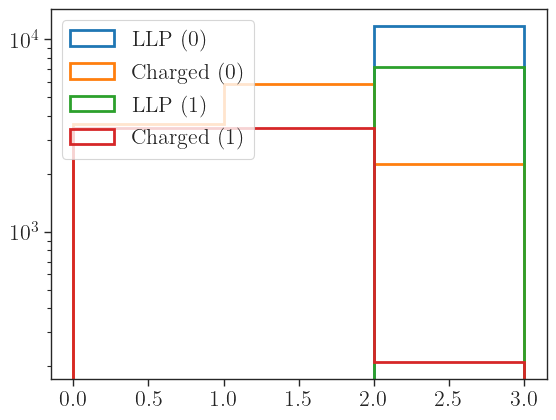

In [18]:
for i in nLLPs_dict:
    h0,_,_ = plt.hist(nLLPs_dict[i],bins=np.arange(0.,4.,1.),label='LLP (%i)' %i,histtype='step',linewidth=2)
    h1,_,_ = plt.hist(nCharged_dict[i],bins=np.arange(0.,4.,1.),label='Charged (%i)' %i,histtype='step',linewidth=2)
    # h1,_,_ = plt.hist(nRhadron,bins=np.arange(0.,4.,1.),label='R-Hadron',histtype='step',linewidth=2)
    # h2,_,_ = plt.hist(nRhadronIso,bins=np.arange(0.,4.,1.),label='R-Hadron (Iso)',histtype='step',linewidth=2,linestyle='dashed')
plt.legend(loc='upper left')
plt.yscale('log')
plt.show()

In [8]:
# plt.hist(RDV,bins=np.arange(0.,1000.,50.),density=True)
# plt.yscale('log')
# plt.show()

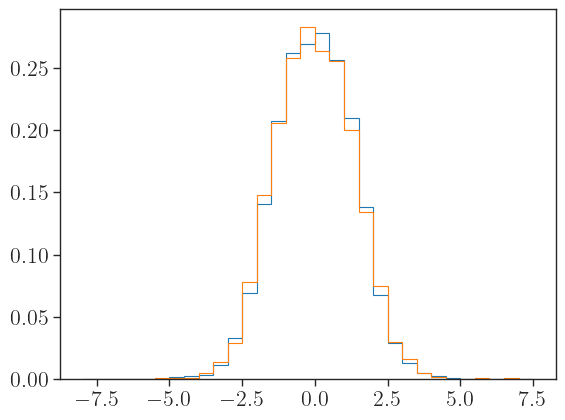

In [17]:
for i in eta_dict:
    plt.hist(eta_dict[i],bins=np.arange(-8.,8.,0.5),density=True,label='%i' %i,histtype='step')
# plt.yscale('log')
plt.show()

In [5]:
print('BSM:')
for p in tree.bsm:
    print(p.PID,p.Mass,p.Status,p.Charge,p.E)

print('\nMothers:')
for p in tree.bsmMothers:
    print(p.PID,p.Mass,p.Status,p.Charge)

print('\nDirect Daughters:')
for p in tree.bsmDirectDaughters:
    print(p.PID,p.Mass,p.Status,p.Charge,p.E)        

print('\nFinal Daughters:')    
for p in tree.bsmFinalDaughters:
    print(p.PID,p.Mass,p.Status,p.E)        

BSM:
-1000005 105.0 102 0 278.7999267578125
1000005 105.0 102 0 213.50521850585938
-1000005 105.0 106 0 275.79241943359375
1000005 105.0 106 0 213.50071716308594

Mothers:
-1000005 105.0 62 0
1000005 105.0 62 0
-1000512 105.5250015258789 104 -999
1000532 105.69999694824219 104 -999

Direct Daughters:
-1000512 105.5250015258789 104 -999 277.17138671875
-1 1.0190191268920898 105 0 2.6765499114990234
21 0.0 105 0 1.3655657768249512
1000532 105.69999694824219 104 -999 214.92405700683594
3 0.25547483563423157 105 0 0.5194672346115112
21 0.0 105 0 3.7477238178253174
-5 4.800000190734863 23 0 12.37946891784668
1000022 100.0 1 0 263.4129333496094
5 4.800000190734863 23 0 12.224841117858887
1000022 100.0 1 0 201.27587890625

Final Daughters:
1000022 100.0 1 263.4129333496094
211 0.13956999778747559 1 1.2628331184387207
-2112 0.9395700097084045 1 2.3863165378570557
2212 0.9382699728012085 1 2.778613567352295
-211 0.13956999778747559 1 1.5005449056625366
211 0.13956999778747559 1 7.12073278427124

In [41]:
print('R-Hadrons:')    
for p in tree.rhadrons:
    print(p.PID,p.Mass,p.Status,p.Charge)  

R-Hadrons:


In [43]:
for p in tree.Particle:
    if abs(p.PID) < 10000:
        continue
    print(p.PID,p.Status,p.E,p.Charge)

1000021 23 1041.9342041015625 0
1000021 23 796.38330078125 0
1000021 44 1212.4788818359375 0
1000021 44 917.5813598632812 0
1000021 44 1120.428466796875 0
1000021 44 961.9528198242188 0
1000021 52 918.4189453125 0
1000021 44 1119.797607421875 0
1000021 44 916.5130004882812 0
1000021 44 1120.2489013671875 0
1000021 44 916.3965454101562 0
1000021 44 1120.2508544921875 0
1000021 44 916.9000854492188 0
1000021 44 1120.30712890625 0
1000021 44 916.86669921875 0
1000021 44 1120.3406982421875 0
1000021 44 916.7699584960938 0
1000021 52 915.73193359375 0
1000021 52 1120.6070556640625 0
1000021 62 1120.5540771484375 0
1000021 62 915.791748046875 0
1000021 101 1116.6351318359375 0
1000021 101 916.2901000976562 0
1000021 102 1116.6351318359375 0
1009002 103 1118.345458984375 -999
1009002 102 1118.345458984375 -999
-1009323 104 1121.6072998046875 -999
1000021 102 916.2901000976562 0
-1009002 103 918.0003662109375 -999
-1009002 102 918.0003662109375 -999
1009333 104 918.8657836914062 -999
1000021 1

In [10]:
print('LLPs:')    
for p in llps:
    print(p.PID,p.Mass,p.Status,p.Charge)  
    print(p.getCharge()) 

LLPs:
-1009002 400.5556945800781 103 -999
Error getting charge for 1000021
None
1009002 400.5556945800781 103 -999
Error getting charge for 1000021
None


In [9]:
candidates = []    
for ip in range(tree.rhadron.GetEntries()):
    rhadron = tree.rhadron.At(ip)
    print('R-hadron:',rhadron.PID)
    # if abs(rhadron.Charge) == 1: # Skip neutral or multicharged particles
        # continue
    
    # Map rhadron to llp (parton)
    # (check which llp came from the R-hadron)
    rhadron_ddaughters = []
    for jp in range(tree.rhadronDaughters.GetEntries()):
        d = tree.rhadronDaughters.At(jp)
        print('  dE=',d.E)
        for llp in llps:
            print(llp.PID,llp.E,llp is d)
        if d.M1 == ip:
            rhadron_ddaughters.append(d)
    print([(d.PID,d.Charge) for d in rhadron_ddaughters])
    totalCharge = sum([d.Charge for d in rhadron_ddaughters])
    x = rhadron_ddaughters[0].X
    totalE = sum([d.E for d in rhadron_ddaughters])
    print('  Charge=',totalCharge,'X=',x,'totalE = ',totalE,rhadron.E)


R-hadron: 1009113


AttributeError: 'TTree' object has no attribute 'rhadronDaughters'

In [21]:
tree.bsmMothers.GetEntries()

0

In [8]:
candidates

[]

In [8]:
for p in tree.isoLLPs:
    # p = tree.bsmFinalDaughters.At(ip)
    print(p.PID,p.Mass,p.Status,p.Charge)

AttributeError: 'TTree' object has no attribute 'isoLLPs'

In [38]:
for ip in range(tree.Particle.GetEntries()):
    p = tree.Particle.At(ip)
    if abs(p.PID) < 10000:
        continue
    if p.Charge == 0:
        continue
    print(p.PID,p.Status,p.Charge,p.Mass)

2212 4 1 0.9382699728012085
2203 63 1 0.7713299989700317
2212 4 1 0.9382699728012085
-1009002 103 -999 400.70001220703125
-1009002 102 -999 400.70001220703125
1009323 104 -999 401.2250061035156
1009002 103 -999 400.5249938964844
1009002 102 -999 400.5249938964844
1009223 104 -999 401.04998779296875
2203 72 1 0.7713299989700317
213 2 1 0.7540422677993774
-211 1 -1 0.13956999778747559
211 1 1 0.13956999778747559
-213 2 -1 0.754854679107666
211 1 1 0.13956999778747559
-213 2 -1 0.7838952541351318
211 1 1 0.13956999778747559
-211 1 -1 0.13956999778747559
213 2 1 1.2140008211135864
-213 2 -1 0.6929205060005188
2212 1 1 0.9382699728012085
-211 1 -1 0.13956999778747559
321 1 1 0.4936800003051758
-211 1 -1 0.13956999778747559
211 1 1 0.13956999778747559
-321 1 -1 0.4936800003051758
211 1 1 0.13956999778747559
211 1 1 0.13956999778747559
-211 1 -1 0.13956999778747559
213 2 1 0.8911933302879333
-211 1 -1 0.13956999778747559
211 1 1 0.13956999778747559
-211 1 -1 0.13956999778747559
321 1 1 0.4936

In [24]:
class Bla(object):

    def __init__(self,x) -> None:
        self.x = None
        self.done = False
        if x != 0:
            self.x = x
        else:
            return
        self.done = True

In [26]:
b = Bla(1)
print(b.x,b.done)

1 True
